# Spectral filtering of financial correlation matrices

This notebook demonstrates theory and practical methods for cleaning financial correlation matrices using Random Matrix Theory (RMT) spectral filtering, with code and explanations. It includes: theory (Marchenko–Pastur), data download, eigenvalue analysis, spectral filtering, comparisons (Ledoit–Wolf shrinkage), and a simple backtest comparing filtered vs raw covariance for minimum-variance portfolios.

## Objectives
- Understand why sample correlation matrices are noisy for financial returns.
- Learn Marchenko–Pastur (MP) law and how to identify noise eigenvalues.
- Implement spectral filtering (RMT clipping) and compare with Ledoit–Wolf shrinkage.
- Evaluate the impact on a minimum-variance portfolio out-of-sample.

## Quick theory (concise)
Given a matrix of standardized asset returns (N assets, T observations) with sample correlation matrix `C`, Random Matrix Theory predicts that for a purely random matrix (no true correlations) the eigenvalue density follows the Marchenko–Pastur distribution.

Let $q = T/N$ (typically we assume $T \ge N$). The MP support for population variance $\sigma^2 = 1$ is:\n$$\lambda_{\pm} = (1 \pm \sqrt{1/q})^2.$$
Eigenvalues of `C` inside $[\lambda_-,\lambda_+]$ are considered mostly noise; eigenvalues outside that interval carry information (market mode, sectors). Spectral filtering replaces noisy eigenvalues (for example by their average) and reconstructs a cleaned correlation matrix.

In [13]:
# Imports and helpers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import linalg, stats
from sklearn.covariance import LedoitWolf
import warnings
warnings.filterwarnings('ignore')
# set seaborn theme if available
try:
    sns.set_theme()
except Exception:
    pass

### Data: download daily prices (example tickers) using `yfinance`. If you don't have `yfinance`, install it with `pip install yfinance`.

In [14]:
# Example tickers (diverse sectors)
tickers = [
    'AAPL','MSFT','GOOG','AMZN','JPM','BAC','XOM','CVX',
    'JNJ','PFE','TSLA','NVDA','META','IBM','ORCL','WMT','HD'
]
start = '2016-01-01'
end = '2023-12-31'

# Download prices (uses yfinance)
try:
    import yfinance as yf
except ImportError:
    raise RuntimeError('yfinance is required. Install with: pip install yfinance')

data = yf.download(tickers, start=start, end=end, progress=False)
if data is None or data.empty:
    raise RuntimeError('Price download failed or returned empty data. Check internet and tickers')
# Prefer adjusted close if present
if 'Adj Close' in data:
    prices = data['Adj Close']
else:
    prices = data

prices = prices.dropna(how='all', axis=1).ffill().dropna()
if prices.shape[1] == 0:
    raise RuntimeError('No valid tickers found after downloading prices')
prices.shape

(2012, 85)

In [15]:
# Compute log returns and sample correlation/covariance
rets = np.log(prices).diff().dropna()
T, N = rets.shape[0], rets.shape[1]
print(f'T = {T}, N = {N}')
# Warn if dataset is small relative to number of assets
import warnings
if T <= N:
    warnings.warn('Number of observations T is less than or equal to number of assets N. Sample covariance is singular; MP bulk may include zero eigenvalues. Consider increasing T or reducing N for stability.', UserWarning)
# Standardize returns (zero mean, unit variance) for correlation analysis
rets_std = (rets - rets.mean()) / rets.std(ddof=0)
C = rets_std.corr().values
cov = rets.cov().values

T = 2011, N = 85


In [16]:
# MP theoretical density and eigen decomposition
def mp_pdf(lambda_vals, q, var=1.0, pts=1000):
    """Return Marchenko-Pastur pdf on grid lambda_vals and the support (lambda_min, lambda_max)."""
    if q <= 0:
        raise ValueError('q must be positive (T/N)')
    lambda_min = var*(1.0 - np.sqrt(1.0/q))**2
    lambda_max = var*(1.0 + np.sqrt(1.0/q))**2
    pdf = np.zeros_like(lambda_vals, dtype=float)
    mask = (lambda_vals >= lambda_min) & (lambda_vals <= lambda_max)
    if mask.any():
        lam = lambda_vals[mask].astype(float)
        denom = np.where(lam == 0.0, np.finfo(float).eps, lam)
        pdf[mask] = (q / (2*np.pi*var*denom)) * np.sqrt((lambda_max - lam)*(lam - lambda_min))
    return pdf, lambda_min, lambda_max

# eigen decomposition of correlation
eigvals, eigvecs = linalg.eigh(C)
# sort ascending -> descending for convenience
order = np.argsort(eigvals)[::-1]
eigvals = eigvals[order]
eigvecs = eigvecs[:, order]
q = T / float(N)
pdf_x = np.linspace(max(0, eigvals.min()*0.9), eigvals.max()*1.1, 200)
mp_vals, lm, lM = mp_pdf(pdf_x, q)
print(f'MP bounds: lambda_minus={lm:.4f}, lambda_plus={lM:.4f}')

MP bounds: lambda_minus=0.6311, lambda_plus=1.4534


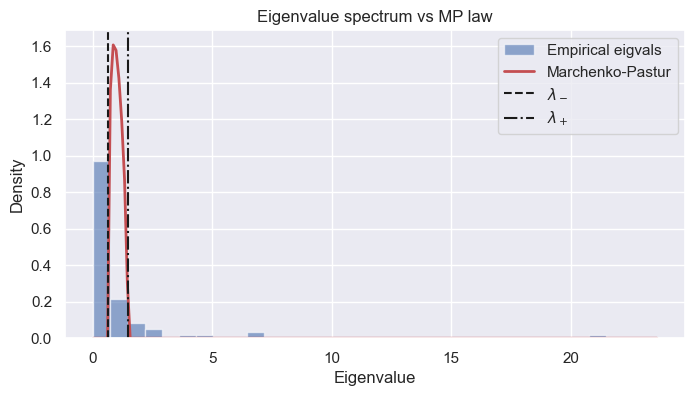

In [17]:
# Plot eigenvalue histogram vs MP law
plt.figure(figsize=(8,4))
plt.hist(eigvals, bins=30, density=True, alpha=0.6, label='Empirical eigvals')
plt.plot(pdf_x, mp_vals, 'r-', lw=2, label='Marchenko-Pastur')
plt.axvline(lm, color='k', linestyle='--', label=r'$\lambda_-$')
plt.axvline(lM, color='k', linestyle='-.', label=r'$\lambda_+$')
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.legend()
plt.title('Eigenvalue spectrum vs MP law')
plt.show()

## Spectral filtering (RMT clipping)
We implement a simple cleaning: replace eigenvalues within the MP bulk by their average (or by a constant), keep outliers intact, then reconstruct the correlation matrix. This often improves stability for inverse problems (portfolio construction).

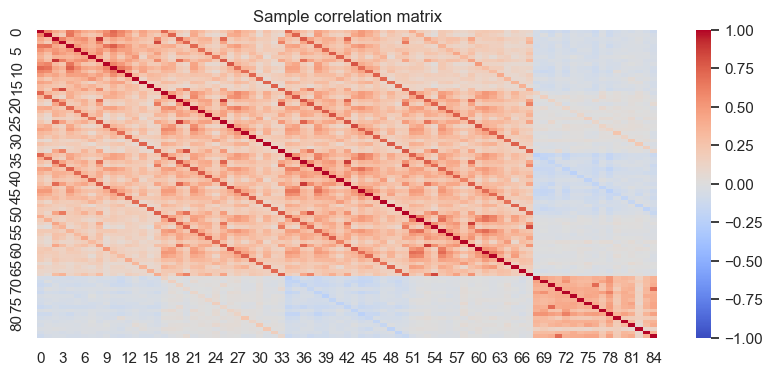

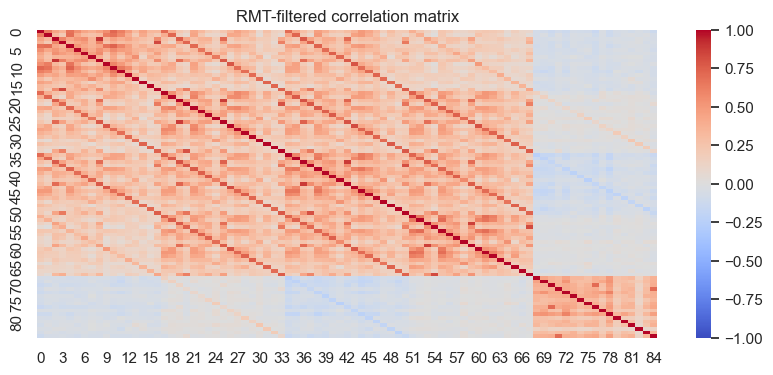

In [18]:
def rmt_filter(C, T, method='clip_mean'):
    # C: sample correlation matrix (NxN), T: number of observations
    N = C.shape[0]
    eigvals, eigvecs = linalg.eigh(C)
    order = np.argsort(eigvals)[::-1]
    vals = eigvals[order].copy()
    vecs = eigvecs[:, order]
    q = T/float(N)
    if q <= 0:
        raise ValueError('Invalid ratio q = T/N; ensure T>0 and N>0')
    # compute Marchenko-Pastur support for correlations (var=1)
    lambda_min = (1.0 - np.sqrt(1.0/q))**2
    lambda_max = (1.0 + np.sqrt(1.0/q))**2
    # indices of noisy eigenvalues (inside MP bulk)
    noisy = (vals >= lambda_min) & (vals <= lambda_max)
    cleaned = vals.copy()
    if method == 'clip_mean':
        # replace noisy eigenvalues by their mean (or by lambda_mean)
        if noisy.any():
            mu = vals[noisy].mean()
            cleaned[noisy] = mu
    elif method == 'zero':
        cleaned[noisy] = 0.0
    else:
        raise ValueError('unknown method')
    # reconstruct
    C_clean = (vecs * cleaned) @ vecs.T
    # enforce diagonal ones (convert to correlation)
    D = np.sqrt(np.diag(C_clean))
    C_clean = C_clean / np.outer(D, D)
    # numerical symmetrize
    C_clean = (C_clean + C_clean.T)/2.0
    return C_clean, vals, cleaned

C_rmt, vals, cleaned_vals = rmt_filter(C, T, method='clip_mean')
plt.figure(figsize=(10,4))
sns.heatmap(C, vmin=-1, vmax=1, cmap='coolwarm', center=0)
plt.title('Sample correlation matrix')
plt.show()
plt.figure(figsize=(10,4))
sns.heatmap(C_rmt, vmin=-1, vmax=1, cmap='coolwarm', center=0)
plt.title('RMT-filtered correlation matrix')
plt.show()

## Compare with Ledoit–Wolf shrinkage (covariance shrinkage)
Ledoit–Wolf provides a well-conditioned covariance estimator. We'll compare the covariance-derived correlation from Ledoit–Wolf to the RMT-filtered correlation.

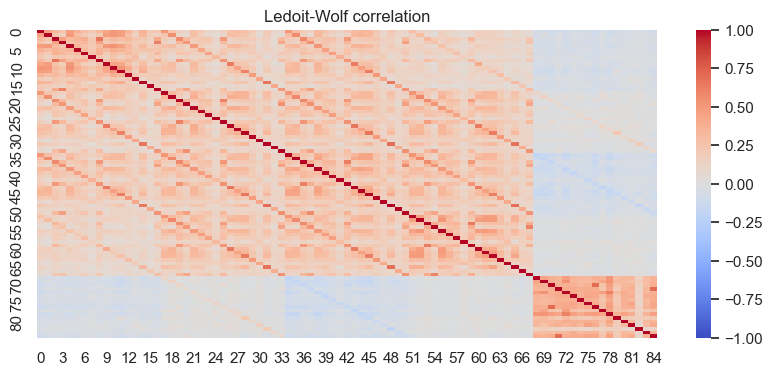

In [19]:
lw = LedoitWolf().fit(rets.values)
cov_lw = lw.covariance_
# convert to correlation
D = np.sqrt(np.diag(cov_lw))
C_lw = cov_lw / np.outer(D, D)
C_lw = (C_lw + C_lw.T)/2.0
plt.figure(figsize=(10,4))
sns.heatmap(C_lw, vmin=-1, vmax=1, cmap='coolwarm', center=0)
plt.title('Ledoit-Wolf correlation')
plt.show()

## Simple rolling backtest: minimum-variance portfolio
We'll compute minimum-variance weights using inverted covariance (with regularization), rebalance monthly using in-sample window, and evaluate out-of-sample realized volatility and cumulative returns. We'll compare three covariance estimates: sample, RMT-filtered (reconstructed from sample correlations but scaled by sample std devs), and Ledoit–Wolf.

Out-of-sample results (daily returns on rebalance days):
Sample: mean/vol = 0.0003565058860935723 0.008632386475347052
RMT-filtered: mean/vol = -0.00034038858486748843 0.00906349062183275
Ledoit-Wolf: mean/vol = 5.575982474432835e-05 0.010203109158881063


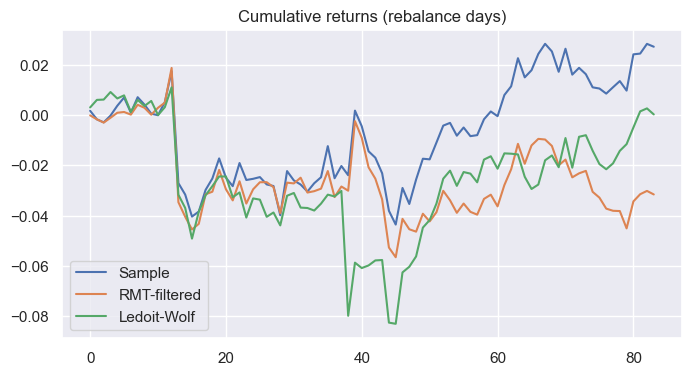

In [20]:
def min_var_weights(cov):
    # returns weights summing to 1 (long-only minimum variance)
    N = cov.shape[0]
    # regularize tiny numerical issues
    cov = cov + np.eye(N) * 1e-8
    iv = np.linalg.inv(cov)
    ones = np.ones(N)
    w = iv @ ones
    w = w / (ones.T @ iv @ ones)
    return w

# Rolling windows
window = 252  # 1 year in trading days
step = 21     # monthly rebalancing approx
dates = rets.index
weights_sample = []
weights_rmt = []
weights_lw = []
oos_returns_sample = []
oos_returns_rmt = []
oos_returns_lw = []
for start in range(0, T - window - 1, step):
    train_slice = slice(start, start + window)
    test_idx = start + window
    X = rets.values[train_slice]  # (window x N)
    # sample cov from train
    cov_sample = np.cov(X, rowvar=False, ddof=0)
    # RMT: build corr from train, filter, then scale by sample stds
    stds = X.std(axis=0, ddof=0)
    C_train = (X - X.mean(axis=0)) / stds
    C_train = np.corrcoef(C_train, rowvar=False)
    C_rmt_train, _, _ = rmt_filter(C_train, window, method='clip_mean')
    cov_rmt = np.outer(stds, stds) * C_rmt_train
    # Ledoit-Wolf on train
    lw = LedoitWolf().fit(X)
    cov_lw = lw.covariance_
    # compute weights
    w_s = min_var_weights(cov_sample)
    w_r = min_var_weights(cov_rmt)
    w_l = min_var_weights(cov_lw)
    # one-day OOS return using next-day returns
    r_oos = rets.values[test_idx]  # shape (N,)
    oos_returns_sample.append(w_s @ r_oos)
    oos_returns_rmt.append(w_r @ r_oos)
    oos_returns_lw.append(w_l @ r_oos)

# aggregate results
rets_s = np.array(oos_returns_sample)
rets_r = np.array(oos_returns_rmt)
rets_l = np.array(oos_returns_lw)
cum_s = (1 + rets_s).cumprod() - 1
cum_r = (1 + rets_r).cumprod() - 1
cum_l = (1 + rets_l).cumprod() - 1
print('Out-of-sample results (daily returns on rebalance days):')
print('Sample: mean/vol =', rets_s.mean(), rets_s.std())
print('RMT-filtered: mean/vol =', rets_r.mean(), rets_r.std())
print('Ledoit-Wolf: mean/vol =', rets_l.mean(), rets_l.std())

plt.figure(figsize=(8,4))
plt.plot(cum_s, label='Sample')
plt.plot(cum_r, label='RMT-filtered')
plt.plot(cum_l, label='Ledoit-Wolf')
plt.legend()
plt.title('Cumulative returns (rebalance days)')
plt.show()

## Notes and next steps
- The MP-based filter is simple; alternatives include eigenvalue clipping to constants, shrinkage of eigenvalues towards their median, or non-linear shrinkage (more advanced).
- Validate stability across different window lengths and asset universes.
- For real trading, add transaction costs, turnover control, and realistic rebalancing schedules.
- Explore factor models (e.g., PCA retaining top k eigenvectors) and compare to RMT-cleaned matrix.

---
References: Bouchaud & Potters, Laloux et al. (1999), Plerou et al. (1999), Ledoit & Wolf.